In [2]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torch
from tqdm import tqdm
from scipy.special import softmax
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.spatial.distance import cosine
import plotly.express as px
from sklearn.manifold import TSNE


/Users/furymeng/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
import pandas as pd
import numpy as np
import glob
import os

def construct_pokedex(csv_path='Pokemon.csv', image_dir='./images/', type_to_load=None, image_extension='.jpg'):
    try:
        pokedex = pd.read_csv(csv_path)
        pokedex["image_path"] = pokedex["Name"].apply(lambda x: next(iter(glob.glob(f"{image_dir}{x}/*{image_extension}")), None))
        pokedex = pokedex.dropna(subset=["image_path"]).reset_index(drop=True)

        pokedex = pokedex.drop_duplicates(subset=['ID'], keep=False).reset_index(drop=True)
        pokedex["Type2"] = pokedex["Type2"].str.strip()
        if type_to_load is not None:
            if isinstance(type_to_load, list):  # Ensure type_to_load is a list
                pokedex = pokedex[pokedex["Type1"].isin(type_to_load)].reset_index(drop=True)
            else:
                print("type_to_load must be a list of types. Filtering by type is skipped.")
        
        return pokedex

    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def load_clip_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14", device=device)
    return model, preprocess, device

def clip_inference_text(model, preprocess, texts, device):
    with torch.no_grad():
        text_embeddings = model.encode_text(clip.tokenize(texts).to(device)).detach().cpu().numpy()
    text_embeddings /= np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
    return text_embeddings

def clip_inference_image(model, preprocess, image_paths, device):
    image_embeddings = []
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for img_path in tqdm(image_paths):
            img = Image.open(img_path).convert("RGB")  # Ensure images are in RGB
            img_preprocessed = preprocess(img).unsqueeze(0).to(device)  # Preprocess and move to the specified device
            image_embedding = model.encode_image(img_preprocessed).detach().cpu().numpy()
            image_embeddings.append(image_embedding)  # Use append instead of += for list

    image_embeddings = np.concatenate(image_embeddings, axis=0)
    image_embeddings /= np.linalg.norm(image_embeddings, axis=-1, keepdims=True)  # Normalize embeddings
    return image_embeddings 

def generate_text_embeddings(clip_model, text_list, computation_device):
    with torch.no_grad():
        tokens = clip.tokenize(text_list).to(computation_device)
        embeddings = clip_model.encode_text(tokens).detach().cpu().numpy()
        embeddings_normalized = embeddings / np.linalg.norm(embeddings, ord=2, axis=-1, keepdims=True)
    return embeddings_normalized



def compute_similarity_text_to_image(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=-1)
    return similarity

def compute_similarity_image_to_text(image_embeddings, text_embeddings):
    similarity = softmax((100.0 * image_embeddings @ text_embeddings.T), axis=0)
    return similarity

def umap_projection(image_embeddings, n_neighbors=15, min_dist=0.1, metric='cosine'):
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, n_components=2)
    visualization_data = reducer.fit_transform(image_embeddings)
    return visualization_data




In [4]:

csv = 'Pokemon.csv'
image = 'images'
pokedex = construct_pokedex(csv_path=csv, image_dir=image)
[model, preprocess, device] = load_clip_model()


100%|██████████| 754/754 [04:31<00:00,  2.78it/s]


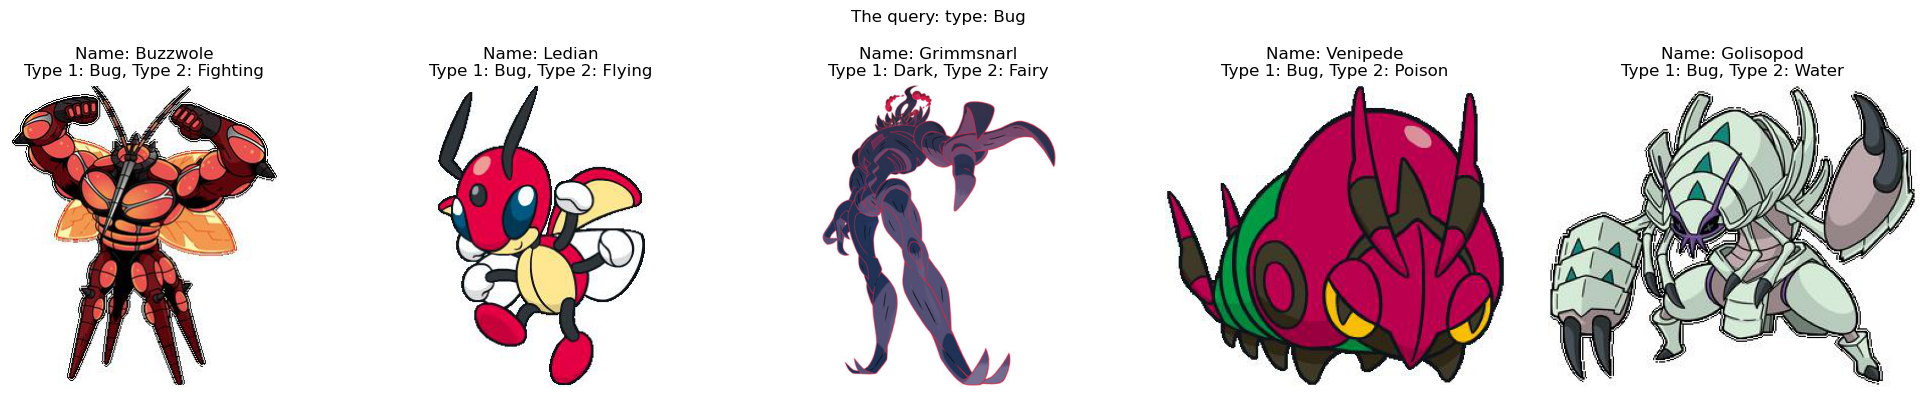

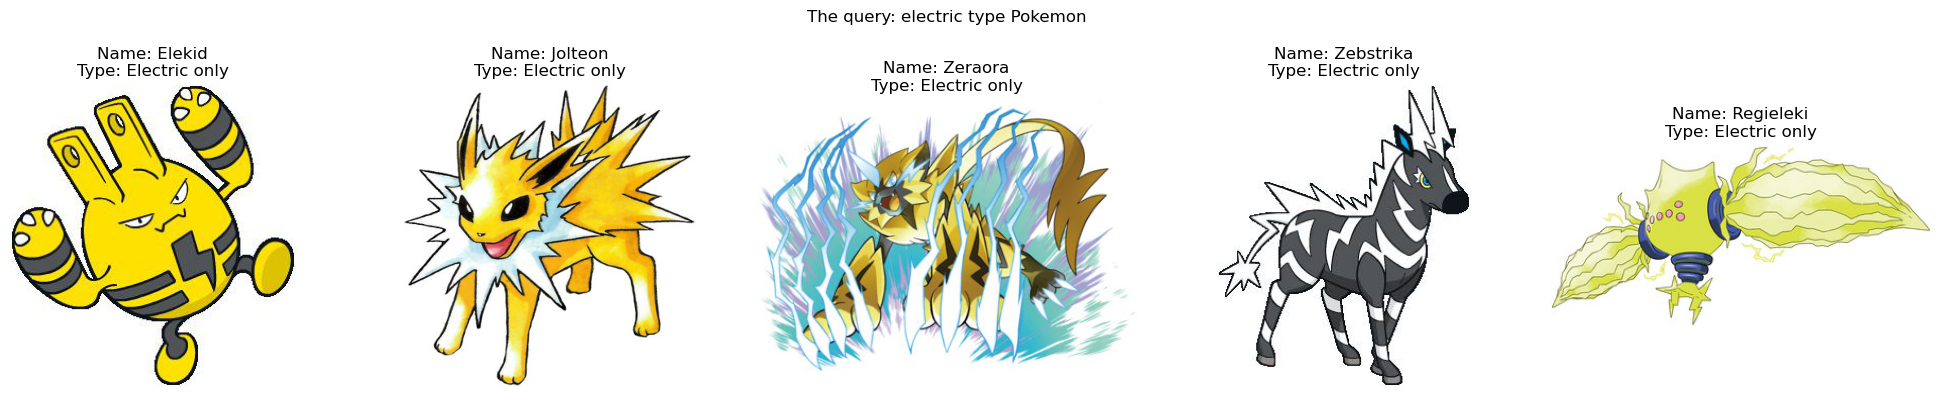

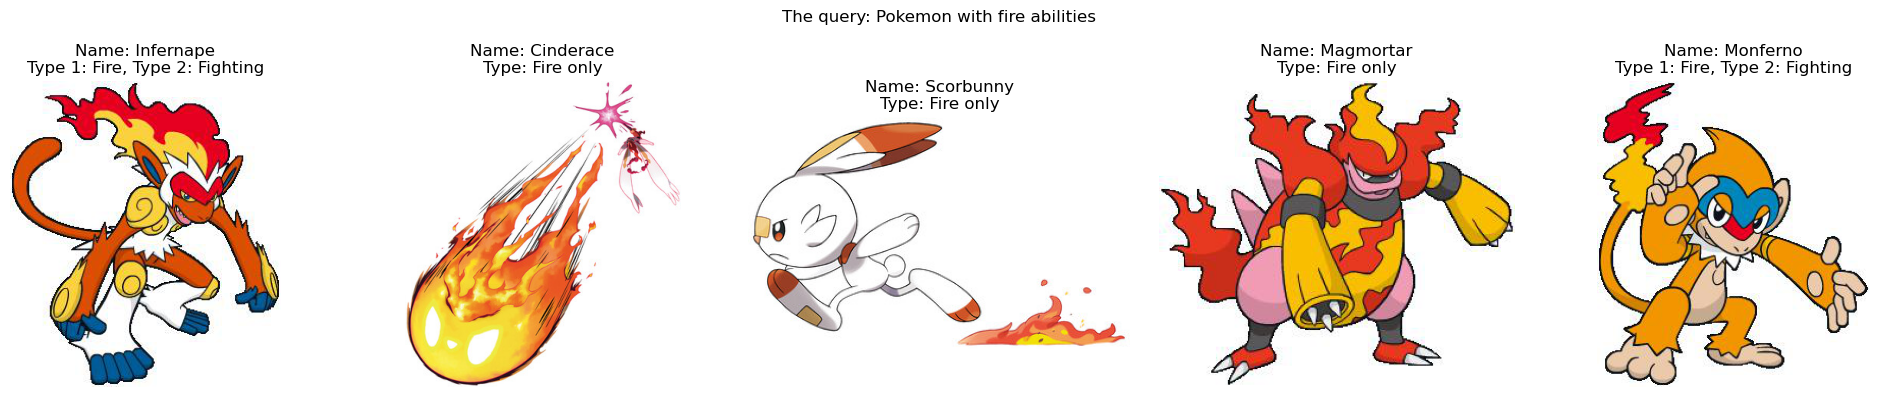

In [6]:
model, preprocess, device = load_clip_model()

# Construct text queries regarding types of Pokemon
text_queries = ["type: Bug", "electric type Pokemon", "Pokemon with fire abilities"]

# Load pokedex and image paths
pokedex = construct_pokedex()
image_paths = pokedex["image_path"].tolist()

# Inference CLIP model on images
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)

# Inference CLIP model on texts
text_embeddings = clip_inference_text(model, preprocess,text_queries, device)

# Compute similarity of texts to each image
similarity = compute_similarity_text_to_image(image_embeddings, text_embeddings)

# Find relevant images for each text query
relevant_images = {}
for i, text_query in enumerate(text_queries):
    relevant_images[text_query] = np.argsort(similarity[:, i])[::-1][:5]

# Display relevant images for each text query
for text_query, relevant_image_indices in relevant_images.items():
    fig, axs = plt.subplots(1, len(relevant_image_indices), figsize=(20, 4))
    for i, image_index in enumerate(relevant_image_indices):
        plt.sca(axs[i])
        image_path = image_paths[image_index]
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')
        name = pokedex["Name"][image_index]
        type1 = pokedex["Type1"][image_index]
        type2 = pokedex["Type2"][image_index]
        if type2 == '':
            plt.title(f"Name: {name}\nType: {type1} only")
        else:
            plt.title(f"Name: {name}\nType 1: {type1}, Type 2: {type2}")
    plt.suptitle(f"The query: {text_query}")
    plt.tight_layout()
    plt.show()

100%|██████████| 754/754 [04:27<00:00,  2.82it/s]


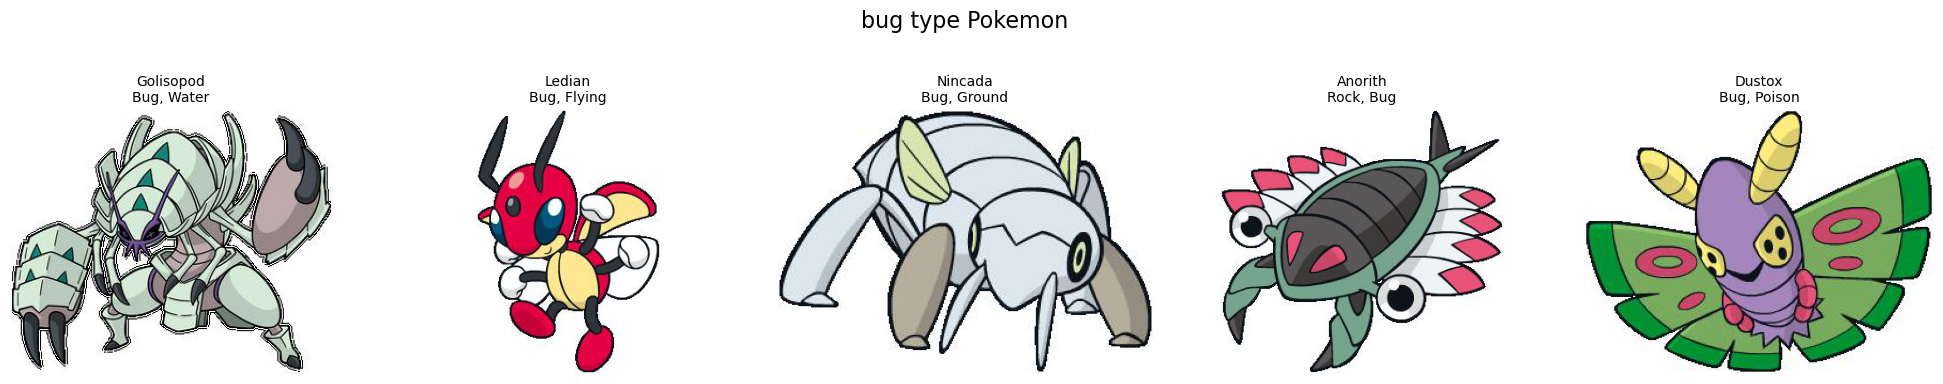

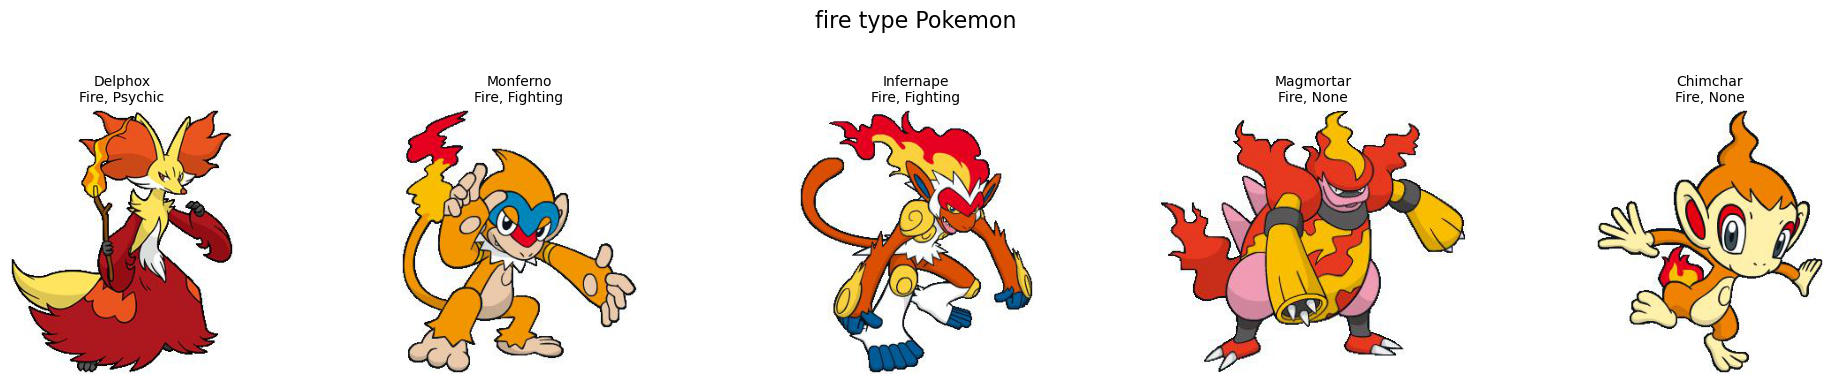

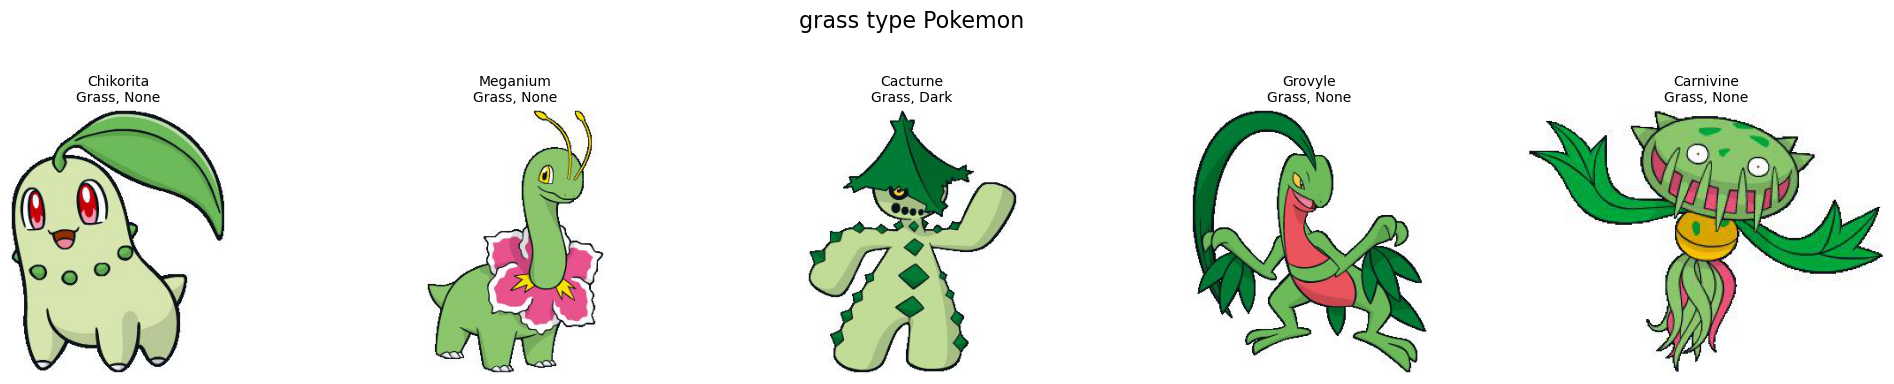

In [7]:
text_queries = ["bug type Pokemon", "fire type Pokemon", "grass type Pokemon"]
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)
text_embeddings = clip_inference_text(model,preprocess,text_queries, device)

similarity = compute_similarity_text_to_image(image_embeddings, text_embeddings)

for query_index, text_query in enumerate(text_queries):
    relevant_image_indices = np.argsort(similarity[:, query_index])[::-1][:5]
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(text_query, fontsize=16)
    
    for subplot_index, image_index in enumerate(relevant_image_indices):
        image_path = image_paths[image_index]
        image = Image.open(image_path)

        axs[subplot_index].imshow(image)
        axs[subplot_index].axis('off')

        name = pokedex.iloc[image_index]["Name"]
        type1 = pokedex.iloc[image_index]["Type1"]
        type2 = pokedex.iloc[image_index]["Type2"] if pokedex.iloc[image_index]["Type2"] else "None"
        axs[subplot_index].set_title(f"{name}\n{type1}, {type2}", fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

  0%|          | 0/754 [00:00<?, ?it/s]

100%|██████████| 754/754 [04:31<00:00,  2.77it/s]


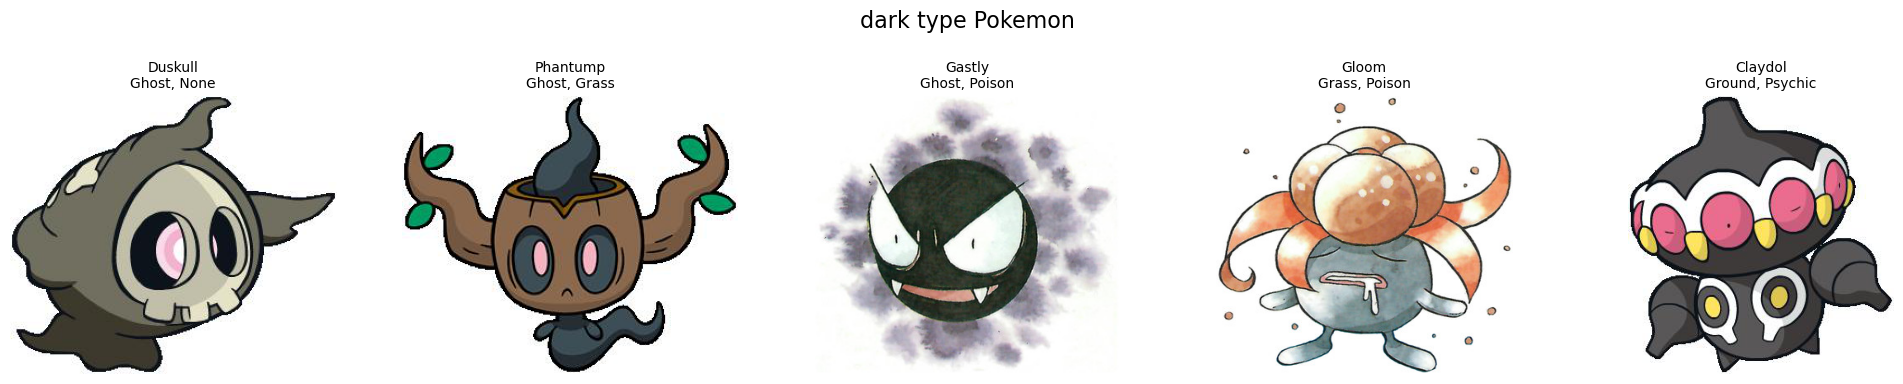

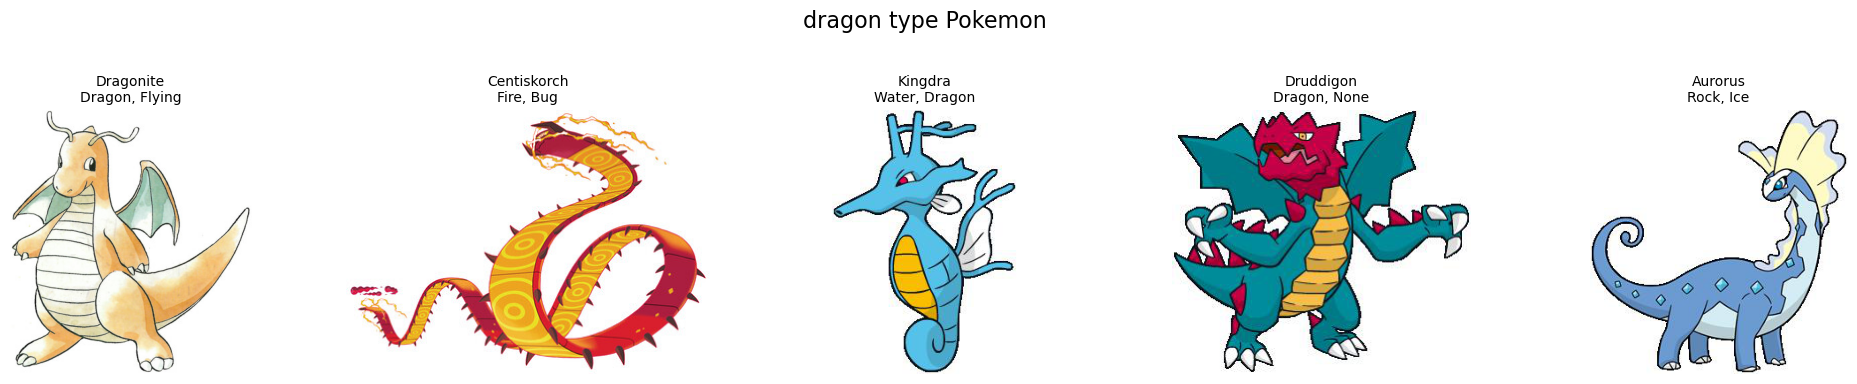

In [8]:
# New text queries for Dark and Dragon types
text_queries = ["dark type Pokemon", "dragon type Pokemon"]
image_embeddings = clip_inference_image(model, preprocess, image_paths, device)
text_embeddings = clip_inference_text(model, preprocess,text_queries, device)

similarity = compute_similarity_text_to_image(image_embeddings, text_embeddings)

for query_index, text_query in enumerate(text_queries):
    relevant_image_indices = np.argsort(similarity[:, query_index])[::-1][:5]

    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(text_query, fontsize=16)
    
    for subplot_index, image_index in enumerate(relevant_image_indices):

        image_path = image_paths[image_index]
        image = Image.open(image_path)

        axs[subplot_index].imshow(image)
        axs[subplot_index].axis('off')

        name = pokedex.iloc[image_index]["Name"]
        type1 = pokedex.iloc[image_index]["Type1"]
        type2 = pokedex.iloc[image_index]["Type2"] if pokedex.iloc[image_index]["Type2"] else "None"
        axs[subplot_index].set_title(f"{name}\n{type1}, {type2}", fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [24]:
selected_pokemon = pokedex.sample(n=10, random_state=42)
pokemon_types = ["Bug", "Electric", "Fire", "Water", "Grass", "Ice", "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug", "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"]
text_queries = [f"type: {ptype}" for ptype in pokemon_types]

image_embeddings = clip_inference_image(model, preprocess, image_paths, device)
text_embeddings = clip_inference_text(model, preprocess,text_queries, device)



100%|██████████| 754/754 [04:45<00:00,  2.64it/s]


In [25]:
def compute_similarities(embeddings1, embeddings2):
    return 1 - np.array([[cosine(e1, e2) for e2 in embeddings2] for e1 in embeddings1])

similarities = compute_similarities(image_embeddings, text_embeddings)
top_5_types_indices = np.argsort(similarities, axis=1)[:, -5:]


Bergmite's Top Predicted Types:
1: Ground (Probability: 0.20)
2: Poison (Probability: 0.20)
3: Electric (Probability: 0.21)
4: Water (Probability: 0.22)
5: Grass (Probability: 0.23)


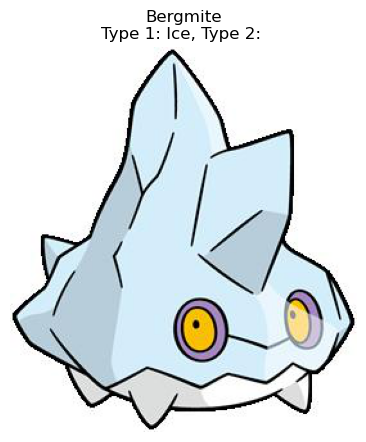


Zangoose's Top Predicted Types:
1: Electric (Probability: 0.20)
2: Dark (Probability: 0.20)
3: Ice (Probability: 0.21)
4: Flying (Probability: 0.21)
5: Fairy (Probability: 0.21)


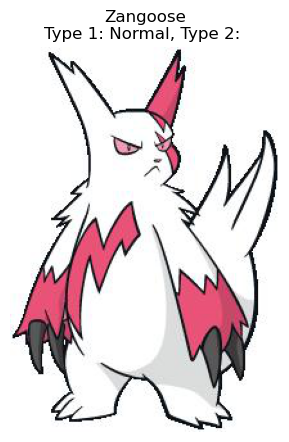


Tapu Fini's Top Predicted Types:
1: Ghost (Probability: 0.19)
2: Poison (Probability: 0.20)
3: Fighting (Probability: 0.20)
4: Ground (Probability: 0.21)
5: Rock (Probability: 0.23)


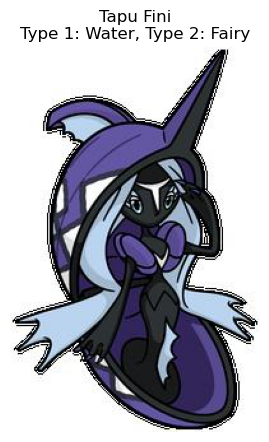


Seadra's Top Predicted Types:
1: Rock (Probability: 0.20)
2: Ground (Probability: 0.20)
3: Poison (Probability: 0.20)
4: Psychic (Probability: 0.21)
5: Ghost (Probability: 0.21)


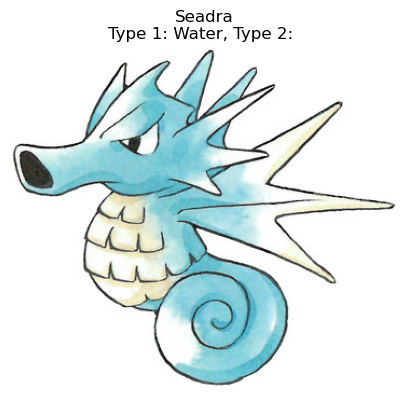


Ralts's Top Predicted Types:
1: Ghost (Probability: 0.21)
2: Rock (Probability: 0.21)
3: Ice (Probability: 0.21)
4: Dark (Probability: 0.21)
5: Steel (Probability: 0.21)


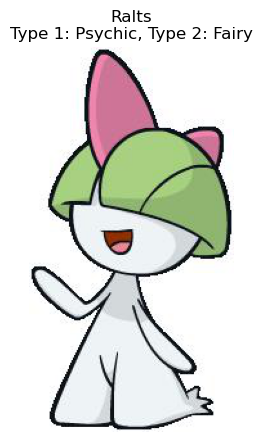


Gliscor's Top Predicted Types:
1: Fighting (Probability: 0.19)
2: Electric (Probability: 0.19)
3: Fire (Probability: 0.19)
4: Ground (Probability: 0.20)
5: Flying (Probability: 0.22)


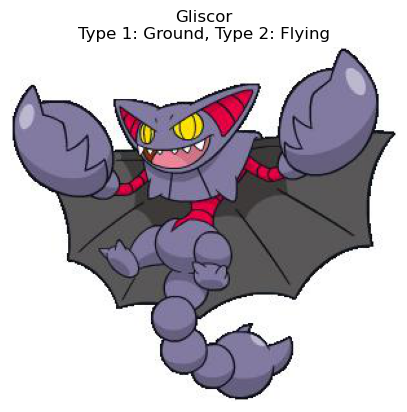


Toxel's Top Predicted Types:
1: Ice (Probability: 0.19)
2: Psychic (Probability: 0.20)
3: Water (Probability: 0.21)
4: Electric (Probability: 0.21)
5: Ghost (Probability: 0.22)


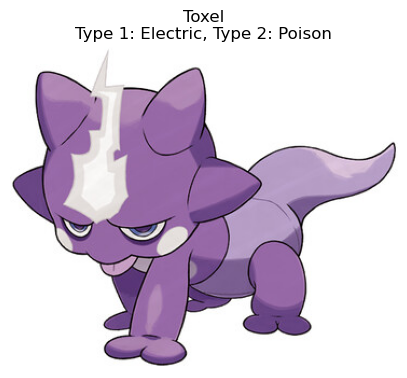


Meltan's Top Predicted Types:
1: Grass (Probability: 0.21)
2: Dark (Probability: 0.21)
3: Fighting (Probability: 0.21)
4: Water (Probability: 0.22)
5: Fire (Probability: 0.24)


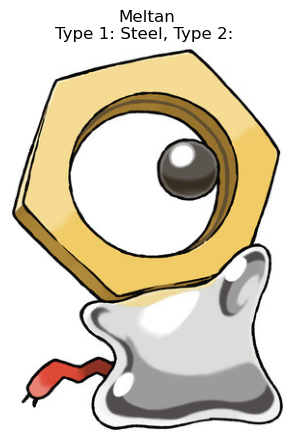


Herdier's Top Predicted Types:
1: Dragon (Probability: 0.22)
2: Electric (Probability: 0.22)
3: Water (Probability: 0.22)
4: Bug (Probability: 0.22)
5: Bug (Probability: 0.22)


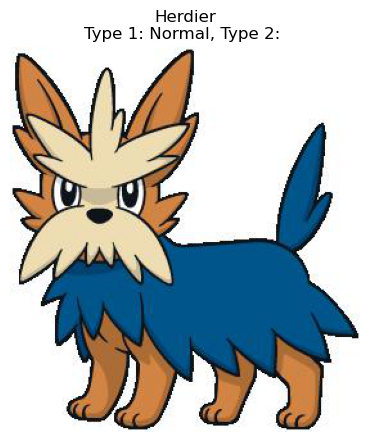


Bewear's Top Predicted Types:
1: Psychic (Probability: 0.21)
2: Rock (Probability: 0.22)
3: Ground (Probability: 0.22)
4: Poison (Probability: 0.22)
5: Water (Probability: 0.23)


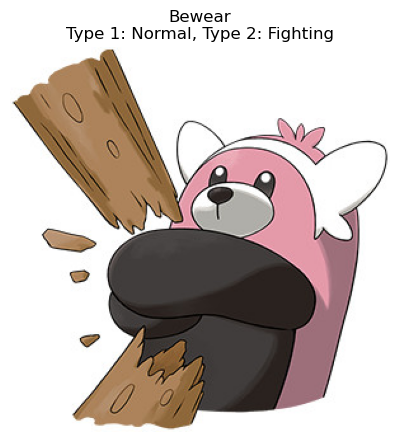

In [26]:
for index, row in selected_pokemon.iterrows():
    image_path = row["image_path"]
    image = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    name = row["Name"]
    type1 = row["Type1"]
    type2 = row["Type2"] if pd.notnull(row["Type2"]) else "None"
    plt.title(f"{name}\nType 1: {type1}, Type 2: {type2}")
    
    # Get top 5 types and their probabilities
    top_types = [pokemon_types[i] for i in top_5_types_indices[index-selected_pokemon.index[0]]]
    top_probs = [similarities[index-selected_pokemon.index[0], i] for i in top_5_types_indices[index-selected_pokemon.index[0]]]
    
    print(f"\n{name}'s Top Predicted Types:")
    for i, (ptype, prob) in enumerate(zip(top_types, top_probs)):
        print(f"{i+1}: {ptype} (Probability: {prob:.2f})")
    
    plt.show()

In [30]:
filtered_pokedex = pokedex[pokedex['Type1'].isin(['Bug', 'Fire', 'Grass'])]
filtered_embeddings = image_embeddings[filtered_pokedex.index]
tsne_embeddings = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(filtered_embeddings)

In [33]:
hover_texts = filtered_pokedex.apply(lambda row: f"{row['Name']} ({row['Type1']}, {row['Type2']})", axis=1)
type_colors = {'Bug': 'green', 'Fire': 'red', 'Grass': 'blue'}
colors = filtered_pokedex['Type1'].map(type_colors)

fig = px.scatter(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1],
                 color=filtered_pokedex['Type1'],
                 color_discrete_map=type_colors,
                 hover_name=hover_texts)

fig.update_traces(marker=dict(size=10),
                  selector=dict(mode='markers'))
fig.update_layout(
    title="t-SNE Visualization of Pokémon Images (Types: Bug, Fire, Grass)",
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    legend_title="Type 1",
    width=600,  
    height=400   
)

fig.show()
